# データマイニングのトライアル（まずはデータ作成のみ）

マイニング対象は
- モデル（とそのパラメータ）
- 入力データ
- 出力データ

## モデル
初回だからシンプルに
- 非線形SVM
- XGBoost

の2種類で試す。モデルパラメータについては、各モデルのパラメータをそれぞれグリッドサーチで探索する

## 入力データ
まずは「E-MiniS&P500-daily-DM-02-use-selected-features.ipynb」で使ったデータを使う。
そこから、指標を組み合わせて何種類かの入力データを作る
- すべて使う
- 「E-MiniS&P500-daily-DM-02-use-selected-features.ipynb」の結果で出てきた上位N個の変数だけ使う

## 出力データ
以下2種類を試す
- これまでと同様に、上昇 or not の二値分類
- X%以上上昇、-X~X%、X%以上下落、という3値分類

In [9]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale

import finalib as fl
import finalib.mine as mi

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# ベースデータ作成

In [10]:
# 生データ
base_dir = 'data/e-mini-sp500-200530'
df_raw = pd.read_csv(f'{base_dir}/e-mini-sp500-daily.csv')

In [11]:
# ベースデータ
N_BARS = 10 # 過去何足分まで見るか
df = fl.make_nbars(df_raw, N_BARS, cols=['Open', 'High', 'Low', 'Close', 'Vol', 'OI'])

In [12]:
# 値動き指標を追加
for i in range(N_BARS+1): # イントラバーの値動き
    df[f'CODiff{i}'] = df[f'Close{i}'] - df[f'Open{i}'] # 終値 - 始値
    df[f'HLDiff{i}'] = df[f'High{i}'] - df[f'Low{i}'] # 高値 - 安値
    df[f'HCDiff{i}'] = df[f'High{i}'] - df[f'Close{i}'] # 高値 - 終値
    df[f'OLDiff{i}'] = df[f'Open{i}'] - df[f'Low{i}'] # 始値 - 安値
    df[f'CLDiff{i}'] = df[f'Close{i}'] - df[f'Low{i}'] # 終値 - 安値
for i in range(N_BARS): # 2足間の値動き
    df[f'CSlope{i}'] = df[f'Close{i}'] - df[f'Close{i+1}'] # ある日の終値 - 前日の終値
    df[f'OSlope{i}'] = df[f'Open{i}'] - df[f'Open{i+1}'] # ある日の始値 - 前日の始値
    df[f'LSlope{i}'] = df[f'Low{i}'] - df[f'Low{i+1}'] # ある日の安値 - 前日の安値
    df[f'HSlope{i}'] = df[f'High{i}'] - df[f'High{i+1}'] # ある日の高値 - 前日の高値
    df[f'VSlope{i}'] = df[f'Vol{i}'] - df[f'Vol{i+1}'] # ある日の出来高 - 前日の出来高
    df[f'OISlope{i}'] = df[f'OI{i}'] - df[f'OI{i+1}'] # ある日の建玉数 - 前日の建玉数
    df[f'HCSlope{i}'] = df[f'High{i}'] - df[f'Close{i+1}'] # ある日の高値 - 前日の終値
    df[f'CLSlope{i}'] = df[f'Close{i+1}'] - df[f'Low{i}'] # ある日の前日の終値 - ある日の安値

In [13]:
# DateをDatetime型にする
df['Date'] = df['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').date())

# 始まりの年月と終わりの年月（終わりは含まない）
s_year, s_month = 1997, 10
e_year, e_month = 2020, 2

df = df[(df['Date'] >= dt.date(s_year,s_month,1)) & (df['Date'] < dt.date(e_year,e_month,1))]
df = df.reset_index(drop=True)
# print('\n始めのデータ\n', df[:1])
# print('\n終わりのデータ\n', df[-1:])

In [14]:
# 年列を入れる
df['year'] = df['Date'].map(lambda date: date.year)
# 月列を入れる
df['month'] = df['Date'].map(lambda date: date.month)
# 曜日列を入れる
day_type = CategoricalDtype(categories=["Mon", "Tue", "Wed", "Thu", "Fri"], ordered=True)
df['day'] = df['Date'].map(lambda d: d.strftime('%a')).astype(day_type)

In [15]:
# 月の上旬・中旬・下旬の列を入れる
# 月初めから7日間を上旬、次の7日間を中旬、それ以降を下旬とする
tdm_type = CategoricalDtype(categories=['Early', 'Mid', 'Late'])
df['tdm'] = 'Early'
y_m = dt.date(s_year, s_month, 1)
while True:
    month_data = df[(df['year'] == y_m.year) & (df['month'] == y_m.month)]['tdm']
    if month_data.size == 0:
        break

    for count, (idx, val) in enumerate(month_data.items()):
        if count > 6 and count < 14:
            df.loc[idx, 'tdm'] = 'Mid'
        elif count >= 14:
            df.loc[idx, 'tdm'] = 'Late'

    y_m = y_m + relativedelta(months=1)

# 機械学習用データ作成

In [18]:
# isUp列追加
# 注意：1なら上昇、0なら横ばいか下降
dfp = df.copy()
#dfp['isUp'] = dfp['CODiff0'].map(lambda x: 1 if x > 0 else 0)
dfp['isUp'] = dfp['CODiff0'] > 0

In [19]:
# ポジティブとネガティブで偏りがないか
dfp.groupby('isUp')['isUp'].count()
# --> あまりない

isUp
False    2613
True     3020
Name: isUp, dtype: int64

In [20]:
# マイニング用データの割合
mine_ratio = 0.8
# マイニングデータのうち、訓練用の割合
train_ratio = 0.8

base_train_df, test_df = fl.split_data(dfp, mine_ratio, purging=True, n_bars=N_BARS+1)

train_df, validation_df = fl.split_data(base_train_df, train_ratio, purging=True, n_bars=N_BARS+1)

print(f'もとデータのサンプル数 = {df.shape[0]}')
print(f'マイニング用データのサンプル数 = {base_train_df.shape[0]}')
print(f'テストデータのサンプル数 = {test_df.shape[0]}')
print(f'いくつのサンプルがパージされたか：{df.shape[0] - base_train_df.shape[0] - test_df.shape[0]}')
print(f'訓練データサンプル数 = {train_df.shape[0]}')
print(f'検証データ（マイニング時のテスト用）サンプル数 = {validation_df.shape[0]}')

もとデータのサンプル数 = 5633
マイニング用データのサンプル数 = 4498
テストデータのサンプル数 = 1125
いくつのサンプルがパージされたか：10
訓練データサンプル数 = 3590
検証データ（マイニング時のテスト用）サンプル数 = 898


訓練データの期間：1997-10-01 - 2011-12-22
検証データの期間：2012-01-10 - 2015-07-29
テストデータの期間：2015-08-13 - 2020-01-31


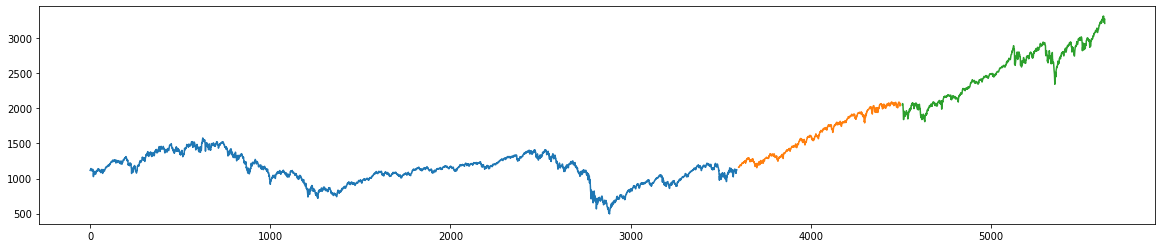

In [25]:
plt.figure(figsize=(20, 4))
train_df['Close0'].plot()
validation_df['Close0'].plot()
test_df['Close0'].plot()

# 各データの期間
print(f"訓練データの期間：{train_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {train_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"検証データの期間：{validation_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {validation_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"テストデータの期間：{test_df['Date'].iloc[0].strftime('%Y-%m-%d')} - {test_df['Date'].iloc[-1].strftime('%Y-%m-%d')}")

In [26]:
# 書き出し
df.to_csv(f'{base_dir}/mine_train_daily-last10days.csv')
df.to_csv(f'{base_dir}/mine_validation_daily-last10days.csv')
df.to_csv(f'{base_dir}/mine_test_daily-last10days.csv')